# DE9IM Class Tests

[DE-9IM](https://en.wikipedia.org/wiki/DE-9IM)


## Setup

### Imports

In [60]:
# Shared Packages
import pandas as pd

# Local functions and classes
from types_and_classes import *
from utilities import *
from debug_tools import *
from structure_slice import *
from metrics import *
from relations import *

### Global Settings

In [61]:
PRECISION = 2

In [62]:
%matplotlib inline

The DE-9IM model is based on a 3×3 intersection matrix with the form:

![DE-9IM Matrix](<Images/DE9IM equations.png>)

where 
_dim_ is the dimension of the intersection (∩) of the interior (I), boundary (B), and exterior (E) of geometries a and b.

Visually, for two overlapping polygonal geometries, the result of the function DE_9IM(a,b) looks like:


![DE_9IM Example](./Images/DE-9IM.png)

This matrix can be serialized. Reading from left-to-right and top-to-bottom, the result is

![DE9IM Linearized](<Images/linearized matrix.png>)

 So, in a compact representation as string code is '212101212'.


The relationship string is converted to binary format, where 'F'
is '0' and '1' or '2' is '1'.

Args:
    poly_a (shapely.MultiPolygon): All contours for a structure on
        a single slice.
    poly_b (shapely.MultiPolygon): All contours for a second
        structure on the same slice.
    relation_str (str): The DE-9IM relationship string for the two

Attributes:
    str (str): A length 9 string of the DE-9IM relationship consisting of
        'F', '1', or '2'.
    relation (str): The relationship string converted to binary format,
        where 'F' becomes '0', and '1' or '2' becomes '1'.

Methods:
    to_int (shift=0): Returns the relationship string converted to an
        integer.  The shift argument shifts the binary equivalent the
        given number of places to the left.

In [63]:
box6 = shapely.MultiPolygon([shapely.Polygon(box_points(6))])
box6
box4 = shapely.MultiPolygon([shapely.Polygon(box_points(4))])
r = DE9IM(box6, box4)
r

<DE9IM>: 212FF1FF2

In [64]:
r.int

457

In [65]:
print(str(r))

|111|
|001|
|001|


In [66]:
b = r.boundary_adjustment('a')
print(str(b))
b

|000|
|111|
|001|


<DE9IM>: FFF212FF2

In [67]:
b = r.boundary_adjustment('b')
print(str(b))
b

|011|
|001|
|001|


<DE9IM>: F22FF1FF2

In [68]:
b = r.transpose()
print(str(b))
b

|100|
|100|
|111|


<DE9IM>: 2FF1FF212

## Tests

### Equals

In [69]:
def equals_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    return a, a


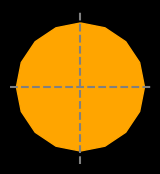

|100|
|010|
|001|


<DE9IM>: 2FFF1FFF2

In [70]:
a, b = equals_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r

RelationshipTest(RelationshipType.EQUALS,
                    0b101010000100010000100000000,
                    0b100010000100010000100000000),
        

### Contains

<link rel="stylesheet" href="relations.css">
<table><tr><td>
<table  style="border: none;">
<tr class="l"  style="border: none;">
<th style="border: none;">Contains</th>
<th width=100 rowspan=2 style="border: none;">
<img src="Images/Relationships/contains simple.png" alt="Contains">
</th></tr>
<tr style="border: none;"><td class="d" style="border: none;">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr></table>
</td><td>
<table class="f">
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>2</td><td>1</td><td>*</td></tr>
    <tr><td>F</td><td>F</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>110110000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>110000000</span></td></tr>
</table>
</tr></tr></table>

In [71]:
mask =  0b110110000
value = 0b110000000


In [72]:
def simple_contains_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b


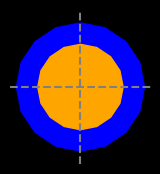

|111|
|001|
|001|


True

In [73]:
a, b = simple_contains_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [74]:
def multiple_contains_example():
    circle4_left = shapely.Polygon(circle_points(2, offset_x=-3))
    circle4_right = shapely.Polygon(circle_points(2, offset_x=3))
    circle3_left = shapely.Polygon(circle_points(1.5, offset_x=-3))
    circle3_right = shapely.Polygon(circle_points(1.5, offset_x=3))
    circle5_up = shapely.Polygon(circle_points(2.5, offset_y=4))
    circle2_up = shapely.Polygon(circle_points(1, offset_y=3))
    circle3_down = shapely.Polygon(circle_points(1.5, offset_y=-2.5))
    circle1_down = shapely.Polygon(circle_points(0.5, offset_y=-2))
    a = StructureSlice([circle4_left, circle4_right, circle5_up, circle3_down])
    b = StructureSlice([circle3_left, circle3_right, circle2_up, circle1_down])
    return a, b


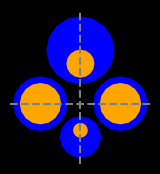

|111|
|001|
|001|


True

In [75]:
a, b = multiple_contains_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

### Overlaps

<link rel="stylesheet" href="relations.css">
<table><tr><td>
<table  style="border: none;">
<tr class="l"  style="border: none;">
<th style="border: none;">Overlaps</th>
<th width=100 rowspan=2 style="border: none;">
<img src="Images/Relationships/overlaps simple.png" alt="Overlaps">
</th></tr>
<tr style="border: none;"><td class="d" style="border: none;">
<span class="a">a</span> and <span class="b">b</span> 
have some but not all points in common.
</td></tr></table>
</td><td>
<table class="f">
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>2</td><td>*</td><td>2</td></tr>
    <tr><td>1</td><td>*</td><td>*</td></tr>
    <tr><td>2</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>111100100</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>111100100</span></td></tr>
</table>
</tr></tr></table>

In [76]:
mask =  0b101100100
value = 0b101100100


In [77]:
def overlaps_simple_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2))
    box4_offset = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([circle6])
    b = StructureSlice([circle6_offset])
    return a, b


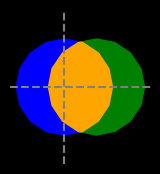

|111|
|101|
|111|


True

In [78]:
a, b = overlaps_simple_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

- In Theory the relation matrix should have the following values:

|R|E|H|
|-|-|-|
|1|1|1|
|1|***1***|1|
|1|1|1|

but it is missing the central value, due to rounding errors.

In [79]:
def overlaps_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle6_offset = shapely.Polygon(circle_points(3, offset_x=2.5))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle6_offset])
    return a, b


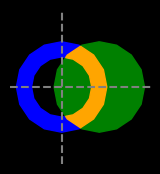

|111|
|101|
|111|


True

In [80]:
a, b = overlaps_ring_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [81]:
def overlaps_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1.5, offset_x=1))

    a = StructureSlice([circle6, circle4])
    b = StructureSlice([circle2])
    return a, b


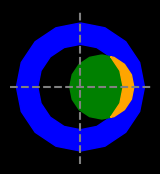

|111|
|101|
|111|


True

In [82]:
a, b = overlaps_surrounded_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [83]:
def overlaps_ring_surrounded_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle3 = shapely.Polygon(circle_points(1.5))
    circle4 = shapely.Polygon(circle_points(2))

    a = StructureSlice([circle6, circle3])
    b = StructureSlice([circle4])
    return a, b


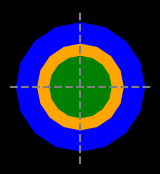

|111|
|101|
|101|


True

In [84]:
a, b = overlaps_ring_surrounded_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [85]:
def overlaps_archipelago_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))
    circle3 = shapely.Polygon(circle_points(1.5))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle3])
    return a, b


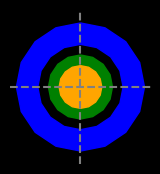

|101|
|101|
|111|


True

In [86]:
a, b = overlaps_archipelago_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [87]:
def overlaps_archipelago_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4])
    return a, b


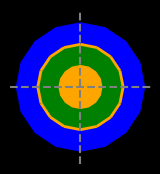

|101|
|111|
|101|


True

In [88]:
a, b = overlaps_archipelago_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

### Inverted Overlap

<link rel="stylesheet" href="relations.css">
- Because we expect that <span class="a">a</span> will always be larger than <span class="b">b</span>, we can expect that the relation below will never be encountered.
<table class="matrix">        
    <tr><td>2</td><td>1</td><td>2</td></tr>
    <tr><td>F</td><td>*</td><td>*</td></tr>
    <tr><td>2</td><td>*</td><td>*</td></tr>
    </table>

In [89]:
def inverted_overlaps_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))

    a = StructureSlice([circle6])
    b = StructureSlice([circle4])
    return a, b


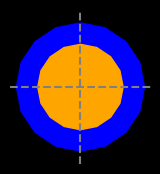

|111|
|001|
|001|


False

In [90]:
a, b = inverted_overlaps_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

### Borders and Confines

- Borders and Confines cannot be distinguished from the region relationship alone.  They require the Exterior relationship as well.

<link rel="stylesheet" href="relations.css">
<table><tr><td>
<table  style="border: none;">
<tr class="l"  style="border: none;">
<th style="border: none;">Borders and Confines</th>
<th width=100 rowspan=2 style="border: none;">
<img src="Images/Relationships/borders.png" alt="Borders"><br>
<img src="Images/Relationships/confines.png" alt="Confines">
</th></tr>
<tr style="border: none;"><td class="d" style="border: none;">
The boundaries of 
<span class="a">a</span> and <span class="b">b</span> 
have more than one point in common, but their interiors do not intersect.
</td></tr></table>
</td><td>
<table class="f">
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>F</td><td>*</td><td>*</td></tr>
    <tr><td>*</td><td>1</td><td>*</td></tr>
    <tr><td>*</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>100010000</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>000010000</span></td></tr>
</table>
</tr></tr></table>

In [91]:
mask =  0b100010000
value = 0b000010000


#### Exterior Borders

In [92]:
def simple_box_borders_example():
    box4_left = shapely.Polygon(box_points(4, offset_x=-2))
    box4_right = shapely.Polygon(box_points(4, offset_x=2))

    a = StructureSlice([box4_left])
    b = StructureSlice([box4_right])
    return a, b


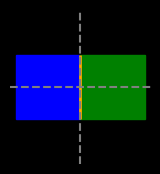

|001|
|011|
|111|


True

In [93]:
a, b = simple_box_borders_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [95]:
def inserted_borders_example():
    box6 = shapely.Polygon(box_points(6))
    box5_up = shapely.Polygon(box_points(5, offset_y=3))
    box6_cropped = shapely.difference(box6, box5_up)

    a = StructureSlice([box6_cropped])
    b = StructureSlice([box5_up])
    return a, b

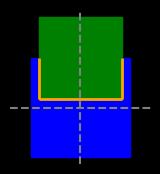

|001|
|011|
|111|


True

In [96]:
a, b = inserted_borders_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

#### Interior Borders (Confines)

In [97]:
def simple_confines_example():
    # 6 cm x 6 cm box with 4cm x 4 cm hole
    box6 = shapely.Polygon(box_points(6))
    box4 = shapely.Polygon(box_points(4))
    a = StructureSlice([box6, box4])
    b = StructureSlice([box4])
    return a, b

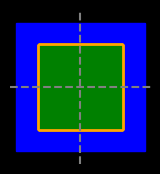

|001|
|011|
|101|


True

In [98]:
a, b = simple_confines_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [99]:
def confines_ring_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))

    # b has internal borders with the ring portion of a, but has an external
    # border with the island part of a. The internal borders relation wins.
    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle4, circle2])
    return a, b

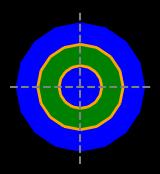

|001|
|011|
|101|


True

In [100]:
a, b = confines_ring_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

# ERROR: Partitions Definition is incorrect

### Partition

<link rel="stylesheet" href="relations.css">
<table><tr><td>
<table  style="border: none;">
<tr class="l"  style="border: none;">
<th style="border: none;">Partition</th>
<th width=100 rowspan=2 style="border: none;">
<img src="Images/Relationships/partitions simple.png" alt="Partition">
</th></tr>
<tr style="border: none;"><td class="d" style="border: none;">
The boundaries of <span class="a">a</span> and <span class="b">b</span> have more than one point in common.
No points of <span class="b">b</span> are exterior to <span class="a">a</span>, and some points in <span class="a">a</span> are exterior to <span class="b">b</span>.
</td></tr></table>
</td><td>
<table class="f">
<tr><th>Matrix</th>
<td><table class="matrix">        
    <tr><td>T</td><td>*</td><td>T</td></tr>
    <tr><td>T</td><td>*</td><td>*</td></tr>
    <tr><td>F</td><td>*</td><td>*</td></tr>
    </table>
    </td>
</tr>
</tr><tr class="bin">
<th>Mask</th><td><span>101100100</span></td></tr>
<tr class="bin">
<th>Value</th><td><span>101100000</span></td></tr>
</table>
</tr></tr></table>

In [101]:
mask =  0b101100100
value = 0b101100000


In [102]:
def simple_partition_example():
    box6 = poly_round(shapely.Polygon(box_points(4)))
    box4_offset = shapely.Polygon(box_points(height=4, width=2, offset_x=-1))
    a = StructureSlice([box6])
    b = StructureSlice([box4_offset])
    return a, b


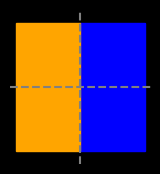

|111|
|011|
|001|


False

In [103]:
a, b = simple_partition_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

In [104]:
def partition_island_example():
    circle6 = shapely.Polygon(circle_points(3))
    circle4 = shapely.Polygon(circle_points(2))
    circle2 = shapely.Polygon(circle_points(1))
    a = StructureSlice([circle6, circle4, circle2])
    b = StructureSlice([circle2])
    return a, b


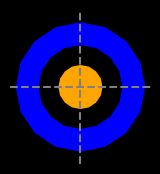

|101|
|011|
|001|


False

In [105]:
a, b = partition_island_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r.test_relation(mask, value)

### Disjoint

In [51]:
def disjoint_example():
    circle4_left = shapely.Polygon(circle_points(4, offset_x=-4.5))
    circle4_right = shapely.Polygon(circle_points(4, offset_x=4.5))

    a = StructureSlice([circle4_left])
    b = StructureSlice([circle4_right])
    return a, b

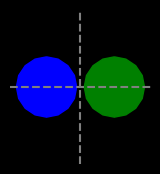

|001|
|001|
|111|


<DE9IM>: FF2FF1212

In [52]:
a, b = disjoint_example()
ax = plot_ab(a.contour, b.contour)


r = DE9IM(a.contour, b.contour)
print(r)
r